In [1]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

a lot of wasted space when looking at images
use filters to find meaningful features
the deeper the covolution layers - the more complex the features that acitvate those deeper neurons
pooling is a way of compressing the image
pooling maintains the features of an image, but shrinks the dimensions - it may even emphasize the features a bit

In [2]:
model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(28,28,1), name='conv1'),
    MaxPooling2D(2,2, name='pool1'), # pooling layer - take maximum value, 2,2 filter size
    Conv2D(64, (3,3), activation='relu', name='conv2'),
    MaxPooling2D(2,2, name='pool2'),
    Flatten(),
    Dense(128, activation='relu', name='dense1'),
    Dense(10, activation='softmax', name='dense2')
    ])

In [3]:
model.summary() # allows you to see the journey of the input

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 26, 26, 64)        640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 11, 11, 64)        36928     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense1 (Dense)               (None, 128)               204928    
_________________________________________________________________
dense2 (Dense)               (None, 10)                1

In [4]:
from tensorflow.keras.preprocessing import image
fashion_mnist_data = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist_data.load_data()
train_images = np.expand_dims(train_images/255, 3)
test_images = np.expand_dims(test_images/255, 3)

In [5]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [9]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95): 
            print("\n Reached 99% accuracy so cancelling training!")
            self.model.stop_training = True 

In [10]:
call_back = myCallback()

In [11]:
model.fit(train_images, train_labels, epochs=10, batch_size=64, callbacks=[call_back])

Epoch 1/10
938/938 [==============================] - 6s 6ms/step - loss: 0.3139 - accuracy: 0.8851
Epoch 2/10
938/938 [==============================] - 6s 7ms/step - loss: 0.2682 - accuracy: 0.9003
Epoch 3/10
938/938 [==============================] - 6s 7ms/step - loss: 0.2363 - accuracy: 0.9129
Epoch 4/10
938/938 [==============================] - 6s 7ms/step - loss: 0.2116 - accuracy: 0.9209
Epoch 5/10
938/938 [==============================] - 6s 7ms/step - loss: 0.1910 - accuracy: 0.9293
Epoch 6/10
938/938 [==============================] - 6s 7ms/step - loss: 0.1719 - accuracy: 0.9361
Epoch 7/10
938/938 [==============================] - 6s 7ms/step - loss: 0.1539 - accuracy: 0.9424
Epoch 8/10
938/938 [==============================] - 6s 7ms/step - loss: 0.1360 - accuracy: 0.9493
Epoch 9/10
938/938 [==============================] - 6s 7ms/step - loss: 0.1199 - accuracy: 0.9554

 Reached 99% accuracy so cancelling training!


under the hood - tensorflow is trying a series of filters on the images, and seeing which ones work by looking at the training data. it greatly reduces the number of features in an image but preserves the informaitve patterns - increasing the accuracy

# how do convolutions work?


In [13]:
import cv2
from scipy import misc
i = misc.ascent()

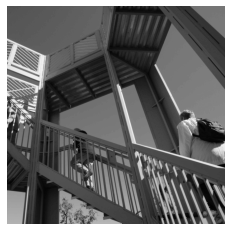

In [14]:
plt.grid(False)
plt.gray()
plt.axis('off')
plt.imshow(i)
plt.show()

In [16]:
i_transformed = np.copy(i)
size_x = i_transformed.shape[0]
size_y = i_transformed.shape[1]
print(size_x, size_y)

512 512


In [17]:
filter1 = [ [0, 1, 0], [1, -4, 1], [0, 1, 0]]
filter2 = [ [-1, -2, -1], [0, 0, 0], [1, 2, 1]]
filter3 = [ [-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]

weight  = 1

In [19]:
def convolution(filter, size_x, size_y):
    for x in range(1,size_x-1):
        for y in range(1,size_y-1):
            convolution = 0.0
            convolution = convolution + (i[x - 1, y-1] * filter[0][0])
            convolution = convolution + (i[x, y-1] * filter[0][1])
            convolution = convolution + (i[x + 1, y-1] * filter[0][2])
            convolution = convolution + (i[x-1, y] * filter[1][0])
            convolution = convolution + (i[x, y] * filter[1][1])
            convolution = convolution + (i[x+1, y] * filter[1][2])
            convolution = convolution + (i[x-1, y+1] * filter[2][0])
            convolution = convolution + (i[x, y+1] * filter[2][1])
            convolution = convolution + (i[x+1, y+1] * filter[2][2])
            convolution = convolution * weight
            if(convolution<0):
                convolution=0
            if(convolution>255):
                convolution=255
            i_transformed[x, y] = convolution
    return i_transformed

In [24]:
def poolinglayer(i_transformed, size_x, size_y): 
    new_x = int(size_x/2)
    new_y = int(size_y/2)
    newImage = np.zeros((new_x, new_y))
    for x in range(0, size_x, 2):
        for y in range(0, size_y, 2):
            pixels = []
            pixels.append(i_transformed[x, y])
            pixels.append(i_transformed[x+1, y])
            pixels.append(i_transformed[x, y+1])
            pixels.append(i_transformed[x+1, y+1])
            newImage[int(x/2),int(y/2)] = max(pixels)
    return newImage

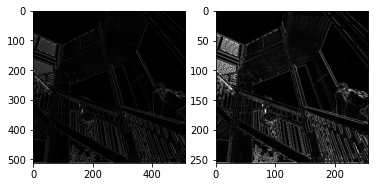

In [34]:
fig, axs = plt.subplots(1, 2)
plt.gray()
plt.grid(False)
axs[0].imshow(convolution(filter1, size_x, size_y))
axs[1].imshow(poolinglayer((convolution(filter1, size_x, size_y)), size_x, size_y))
plt.show()   

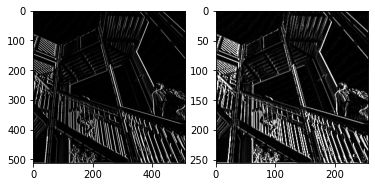

In [35]:
fig, axs = plt.subplots(1, 2)
plt.gray()
plt.grid(False)
axs[0].imshow(convolution(filter2, size_x, size_y))
axs[1].imshow(poolinglayer((convolution(filter2, size_x, size_y)), size_x, size_y))
plt.show()   

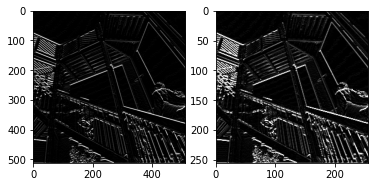

In [36]:
fig, axs = plt.subplots(1, 2)
plt.gray()
plt.grid(False)
axs[0].imshow(convolution(filter3, size_x, size_y))
axs[1].imshow(poolinglayer((convolution(filter3, size_x, size_y)), size_x, size_y))
plt.show()   

# Assignment

In [45]:
def train_mnist():
    mnist = tf.keras.datasets.mnist

    (x_train, y_train),(x_test, y_test) = mnist.load_data()
    x_train = np.expand_dims(x_train/255, 3)
    x_test = np.expand_dims(x_test/255, 3)
    model = Sequential([
        Conv2D(64, (3,3), activation='relu', input_shape=(28,28,1), name='conv1'),
        MaxPooling2D(2,2, name='pool1'), # pooling layer - take maximum value, 2,2 filter size
        Flatten(),
        Dense(128, activation='relu', name='dense1'),
        Dense(10, activation='softmax', name='dense2')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train, epochs=20, callbacks=[callback])

    return history.epoch

In [46]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.998): 
            print("\n Reached 99.8% accuracy so cancelling training!")
            self.model.stop_training = True 

In [47]:
callback = myCallback()

In [48]:
train_mnist()

Epoch 1/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2666 - accuracy: 0.9200
Epoch 2/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0506 - accuracy: 0.9854
Epoch 3/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0281 - accuracy: 0.9914
Epoch 4/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0151 - accuracy: 0.9954
Epoch 5/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0104 - accuracy: 0.9968
Epoch 6/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0082 - accuracy: 0.9973
Epoch 7/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0065 - accuracy: 0.9976

 Reached 99.8% accuracy so cancelling training!


[0, 1, 2, 3, 4, 5, 6]